In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import preprocess_input
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dense, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image
from matplotlib import image as im
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
import numpy as np
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp '/content/drive/MyDrive/Colab Notebooks/training.zip' /content 
!cp '/content/drive/MyDrive/Colab Notebooks/testing.zip' /content
!unzip '/content/training.zip'
!unzip '/content/testing.zip'

Streaming output truncated to the last 5000 lines.
  inflating: training/dog/dog.6400.jpg  
  inflating: training/dog/dog.6401.jpg  
  inflating: training/dog/dog.6402.jpg  
  inflating: training/dog/dog.6403.jpg  
  inflating: training/dog/dog.6404.jpg  
  inflating: training/dog/dog.6405.jpg  
  inflating: training/dog/dog.6406.jpg  
  inflating: training/dog/dog.6407.jpg  
  inflating: training/dog/dog.6408.jpg  
  inflating: training/dog/dog.6409.jpg  
  inflating: training/dog/dog.641.jpg  
  inflating: training/dog/dog.6410.jpg  
  inflating: training/dog/dog.6411.jpg  
  inflating: training/dog/dog.6412.jpg  
  inflating: training/dog/dog.6413.jpg  
  inflating: training/dog/dog.6414.jpg  
  inflating: training/dog/dog.6415.jpg  
  inflating: training/dog/dog.6416.jpg  
  inflating: training/dog/dog.6417.jpg  
  inflating: training/dog/dog.6418.jpg  
  inflating: training/dog/dog.6419.jpg  
  inflating: training/dog/dog.642.jpg  
  inflating: training/dog/dog.6420.jpg  
  inflat

In [4]:
train_path="/content/training"
test_path="/content/testing"
validation_path = "/content/validation"
os.mkdir(validation_path)
os.mkdir(validation_path + '/cat')
os.mkdir(validation_path + '/dog')
IMG_SIZE = (224, 224)

In [5]:
validation_cat = round(len(os.listdir(train_path + '/cat')) * 0.1)
validation_dog = round(len(os.listdir(train_path + '/dog')) * 0.1)
count = 0
for i in os.listdir(train_path + '/cat'):
  count += 1
  shutil.move(train_path + '/cat/' + i, validation_path + '/cat/')
  if count == validation_cat:
    break
count = 0
for i in os.listdir(train_path + '/dog'):
  count += 1
  shutil.move(train_path + '/dog/' + i, validation_path + '/dog/')
  if count == validation_dog:
    break

In [6]:
BATCH_SIZE = 64
train_dataset = tf.keras.utils.image_dataset_from_directory(train_path,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            label_mode = 'binary'
                                                            )
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_path,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                            label_mode = 'binary'
                                                                 )
test_dataset = tf.keras.utils.image_dataset_from_directory(test_path,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                            label_mode = 'binary')

Found 22500 files belonging to 2 classes.
Found 2500 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', mode='min',verbose=1,patience=5),
         ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
#Early stopping to avoid overfitting of model

['cat', 'dog']


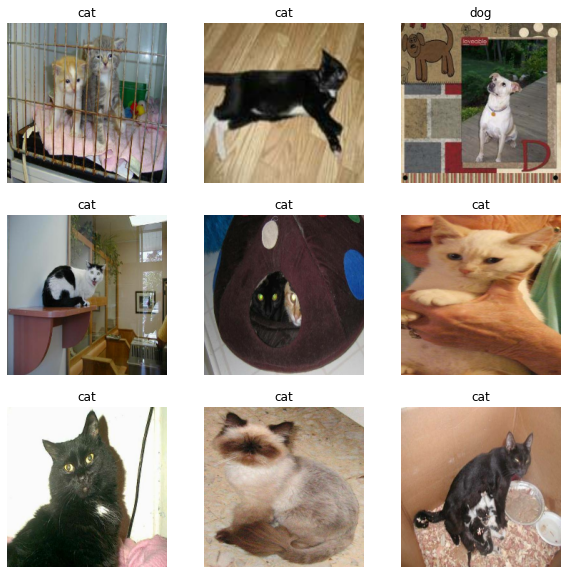

In [8]:
# Show the first nine images and labels from the training set 
class_names = train_dataset.class_names
print(class_names)
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(labels[i])])
    plt.axis("off")

In [9]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)
])

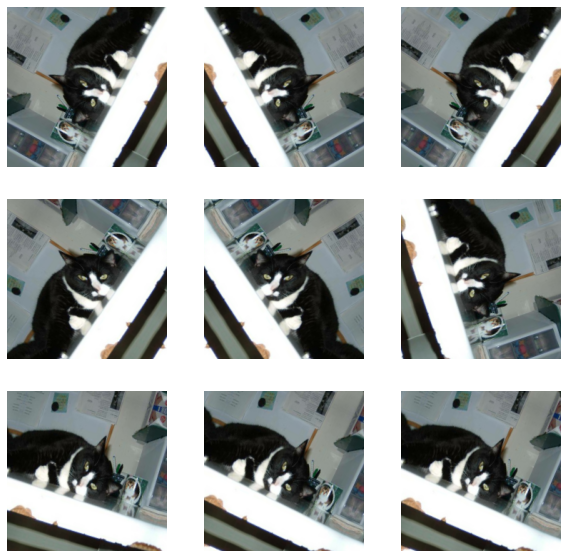

In [10]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [11]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [12]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 7, 7, 1280)


In [14]:
base_model.trainable = False

In [15]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 1280)


In [20]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer='l2')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 1)


In [21]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [22]:
base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [24]:
len(model.trainable_variables)

2

In [25]:
initial_epochs = 20

loss0, accuracy0 = model.evaluate(test_dataset)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


16/16 [==============================] - 5s 158ms/step - loss: 0.8248 - binary_accuracy: 0.4140


In [26]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.82
initial accuracy: 0.41


In [27]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    shuffle = True,
                    callbacks = callbacks)

Epoch 1/20
352/352 [==============================] - 61s 164ms/step - loss: 0.6603 - binary_accuracy: 0.6401 - val_loss: 0.5517 - val_binary_accuracy: 0.7708
Epoch 2/20
352/352 [==============================] - 58s 162ms/step - loss: 0.5431 - binary_accuracy: 0.7559 - val_loss: 0.4444 - val_binary_accuracy: 0.8700
Epoch 3/20
352/352 [==============================] - 57s 159ms/step - loss: 0.4611 - binary_accuracy: 0.8237 - val_loss: 0.3666 - val_binary_accuracy: 0.9192
Epoch 4/20
352/352 [==============================] - 57s 160ms/step - loss: 0.3961 - binary_accuracy: 0.8638 - val_loss: 0.3096 - val_binary_accuracy: 0.9376
Epoch 5/20
352/352 [==============================] - 58s 164ms/step - loss: 0.3521 - binary_accuracy: 0.8868 - val_loss: 0.2671 - val_binary_accuracy: 0.9532
Epoch 6/20
352/352 [==============================] - 58s 163ms/step - loss: 0.3154 - binary_accuracy: 0.9036 - val_loss: 0.2343 - val_binary_accuracy: 0.9592
Epoch 7/20
352/352 [==========================

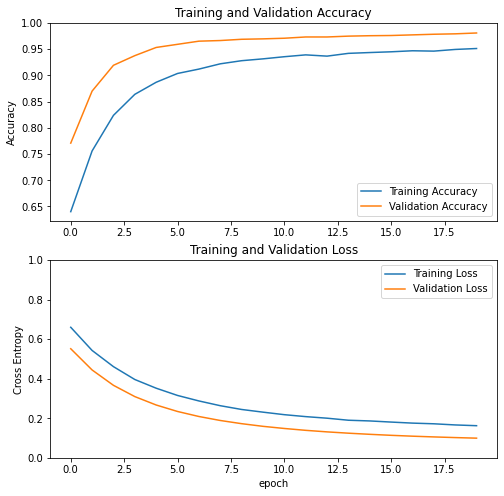

In [28]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [30]:
loss0, accuracy0 = model.evaluate(test_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0 * 100))

16/16 [==============================] - 3s 115ms/step - loss: 0.1236 - binary_accuracy: 0.9750
initial loss: 0.12
initial accuracy: 97.50


In [40]:
!unzip '/content/predict.zip'

Archive:  /content/predict.zip
   creating: predict/
  inflating: __MACOSX/._predict      
   creating: predict/cat/
  inflating: __MACOSX/predict/._cat  
  inflating: predict/.DS_Store       
  inflating: __MACOSX/predict/._.DS_Store  
   creating: predict/dog/
  inflating: __MACOSX/predict/._dog  
  inflating: predict/cat/flickr_cat_000023.jpg  
  inflating: __MACOSX/predict/cat/._flickr_cat_000023.jpg  
  inflating: predict/cat/flickr_cat_000022.jpg  
  inflating: __MACOSX/predict/cat/._flickr_cat_000022.jpg  
  inflating: predict/cat/flickr_cat_000020.jpg  
  inflating: __MACOSX/predict/cat/._flickr_cat_000020.jpg  
  inflating: predict/cat/flickr_cat_000021.jpg  
  inflating: __MACOSX/predict/cat/._flickr_cat_000021.jpg  
  inflating: predict/cat/flickr_cat_000009.jpg  
  inflating: __MACOSX/predict/cat/._flickr_cat_000009.jpg  
  inflating: predict/cat/flickr_cat_000019.jpg  
  inflating: __MACOSX/predict/cat/._flickr_cat_000019.jpg  
  inflating: predict/cat/flickr_cat_000018.jp

Found 1000 files belonging to 2 classes.
['cat', 'dog']
Predictions:
 [1 1 1 0 1 0 0 1 1 1 0 0 1 0 1 0 0 1 0 0 1 0 0 1 0 0 1 1 1 1 0 0 1 0 1 1 0
 0 1 1 1 1 0 1 0 1 0 1 1 0 0 1 1 0 0 1 1 1 0 0 1 1 1 1]
Labels:
 [[1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]]


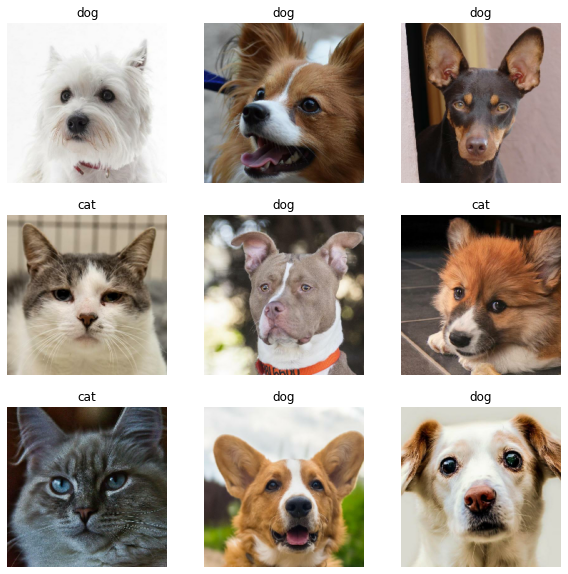

In [45]:
predict_dataset = tf.keras.utils.image_dataset_from_directory('/content/testing',
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                              label_mode='binary')
print(predict_dataset.class_names)
# Retrieve a batch of images from the test set
image_batch, label_batch = predict_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
# Apply a sigmoid since our model returns logits
# predictions = tf.nn.sigmoid(predictions)
# print(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

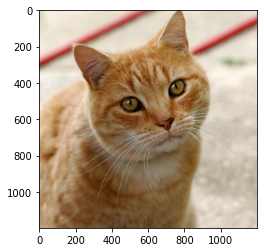

1/1 [==============================] - 0s 32ms/step
[[0.00915731]]
Predicted Animal: Cat


In [55]:
# img_path = 'testing/cat/flickr_cat_000008.jpg'
# img_path = 'testing/dog/flickr_dog_000043.jpg'
# img_path = 'validation/cat/cat.10000.jpg'
# img_path = 'validation/dog/dog.10004.jpg'
img_path = 'Cat03.jpg'
# img_path = 'dog4.jpg'
# img_path = 'dog2.jpg'
# img_path = 'predict_cat.jpg'
img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
data = plt.imread(img_path)
plt.imshow(data)
plt.show()
x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)
# x = tf.keras.applications.inception_v3.preprocess_input(x)
preds = model.predict(x)
print(preds)
# preds = tf.nn.sigmoid(x)
preds = tf.where(preds[0] < 0.5, 0, 1)
if(preds > 0):
  pet = "Dog"
else:
  pet = "Cat"
# print(preds[0])
print("Predicted Animal: " + pet)
# print(preds)

# predictions = tf.nn.sigmoid(preds)
# print(predictions)
# predictions = tf.where(predictions < 0.5, 0, 1)
# # print(predictions)
# class_names[predictions[0][0]]